In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train PyTorch model on Vertex AI with data from Cloud Storage

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/training/pytorch_gcs_data_training.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/training/pytorch_gcs_data_training.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/training/pytorch_gcs_data_training.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Overview

This tutorial shows you how to create a custom training job using PyTorch and a dataset stored on Cloud Storage.

Learn more about [PyTorch integration in Vertex AI](https://cloud.google.com/vertex-ai/docs/start/pytorch).

### Objective

In this tutorial, you learn how to create a training job using PyTorch and a dataset stored on Cloud Storage. You build a custom training script that uses GCSFuse to load data from a bucket. The custom training script creates a simple neural network and saves the model artifact to a bucket on Cloud Storage.

This tutorial uses the following Google Cloud ML services and resources:

- Vertex AI Training
- Cloud Storage

The steps performed include:

- Write a custom training script that creates your train & test datasets and trains the model.
- Run a Vertex AI SDK `CustomTrainingJob`

### Dataset

This tutorial uses the [MNIST handwriting sample](https://en.wikipedia.org/wiki/MNIST_database) that classifies hand-written digits. For this tutorial, a CSV version of the dataset available on [Kaggle](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv?select=mnist_train.csv) has been uploaded to a Cloud Storage bucket for your use.

### Costs 

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing),
and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), 
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Requirements

This tutorial requires using a notebook that is optimized for use with PyTorch. If you run this notebook in Vertex AI Workbench, ensure that you notebook image meets the following requirements:

+ PyTorch 1.13 notebook
+ 1 NVIDIA T4 GPU

Colab notebooks meet the requirements (after installation and authentication). You might need to switch to a GPU-enabled runtime.

## Installation

Install the following packages required to execute this notebook. 

In [ ]:
%%writefile requirements.txt

google-cloud-aiplatform
google-cloud-storage
torch==1.12

In [ ]:
%pip install -q -r requirements.txt

### Colab only: Uncomment the following cell to restart the kernel

In [ ]:
# Automatically restart kernel after installs so that your environment can access the new packages
# import IPython

# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). 

4. [Enable the Storage API](https://console.cloud.google.com/flows/enableapi?apiid=storage.googleapis.com).

5. If you are running this notebook locally, you need to install the [Cloud SDK](https://cloud.google.com/sdk).

#### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [1]:
PROJECT_ID = "northam-ce-mlai-tpu"  # @param

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations).

In [2]:
REGION = "us-central1"  # @param

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may have to manually authenticate. Follow the relevant instructions below.

**1. Vertex AI Workbench**
* Do nothing as you are already authenticated.

**2. Local JupyterLab instance, uncomment and run:**

In [ ]:
# ! gcloud auth login

**3. Colab, uncomment and run:**

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

**4. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [3]:
BUCKET_URI = f"gs://jharding-{PROJECT_ID}-unique"  # @param {type:"string"}
BUCKET_PREFIX = "pytorch-on-gcs"  # @param

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [4]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

Creating gs://jharding-northam-ce-mlai-tpu-unique/...


### Import libraries

In [1]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from google.cloud import aiplatform
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

### Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project.

In [6]:
aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

### Provide the URIs for the data

As mentioned before, this tutorial uses the classic MNIST handwritten digits dataset as an input. The dataset has been stored for your use on a publicly available Cloud Storage location. You can use these CSV files directly in your training script.

**Note**: You can use the [PyTorch datasets library](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) to download a this dataset. For learning purposes, this tutorial uses a copy of the dataset on Cloud Storage.

In [7]:
TRAIN_URI = "gs://cloud-samples-data/vertex-ai/training/pytorch/mnist_train.csv"
TEST_URI = "gs://cloud-samples-data/vertex-ai/training/pytorch/mnist_test.csv"

print(TRAIN_URI)
print(TEST_URI)

gs://cloud-samples-data/vertex-ai/training/pytorch/mnist_train.csv
gs://cloud-samples-data/vertex-ai/training/pytorch/mnist_test.csv


## [OPTIONAL] Inspect the dataset from GCS

Before creating the training script, take a quick look at the data contained in the CSV files on Cloud Storage. You can use the PyTorch [`Dataset`](https://pytorch.org/docs/stable/data.html?highlight=torch+utils+data+dataset#torch.utils.data.Dataset) and [`DataLoader`](https://pytorch.org/docs/stable/data.html?highlight=torch+utils+data+dataset#torch.utils.data.DataLoader) classes to instantiate a dataset and then plot the data using [matplotlib](https://matplotlib.org/stable/index.html).

Start by downloading the CSV files into your local development environment.

In [10]:
! gsutil -m cp -r $TRAIN_URI .
! gsutil -m cp -r $TEST_URI .

Copying gs://cloud-samples-data/vertex-ai/training/pytorch/mnist_train.csv...
\ [1/1 files][104.6 MiB/104.6 MiB] 100% Done                                    
Operation completed over 1 objects/104.6 MiB.                                    
Copying gs://cloud-samples-data/vertex-ai/training/pytorch/mnist_test.csv...
/ [1/1 files][ 17.5 MiB/ 17.5 MiB] 100% Done                                    
Operation completed over 1 objects/17.5 MiB.                                     


Next you need to define a custom image dataset that inherits from the base `Dataset` class. 

Note that your custom `Dataset` class must override the `__init__`, `__len__`, and `__getitem__` methods. These methods are used by the `DataLoader` class to iterate through your dataset.

The following `CustomImageDataset` class has a several notable features. First, the dimensions of images are hardcoded as 28 pixels high by 28 pixels wide. This corresponds to the dimensions of the images in the MNIST dataset.

Second, this dataset uses [`pandas.Dataframe`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) objects for reading the CSV files and accessing the data inside of them.

Finally, the `__getitem__` method needs to extract the image and the label out of each row in the CSV file. These two values are provided to the caller as a tuple.

The image itself needs to be converted from a one-dimensional vector value (a list) into a 2-dimensional matrix (a list of lists). In addition, the grayscale values in the CSV files, stored as integers, need to be converted into a float value between 0.0 and 1.0. To do this conversion, you multiple the grayscale value by the decimal equivalent of 1/255.

In [11]:
class CustomImageDataset(Dataset):
    width = 28  # hard-coded width & height of image matrix
    height = 28

    def __init__(self, data_file, transform=None, target_transform=None):
        self.dataset = pd.read_csv(data_file)
        self.transform = (
            transform  # We would use ToTensor() if we were taking in raw images
        )
        self.target_transform = target_transform

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        label = self.dataset.at[idx, "label"]
        image = self.dataset.iloc[idx, 1:]

        # Create a matrix from the pandas.Series
        image = image.to_numpy() * 0.00392156862745098  # 1 / 255
        image = image.reshape(self.width, self.height)
        image = image.astype(float)
        image = torch.Tensor(image)

        if self.target_transform:
            label = self.target_transform(label)
        if self.transform:
            image = self.transform(image)
        return image, label

In [12]:
train_set = CustomImageDataset("mnist_train.csv")
test_set = CustomImageDataset("mnist_test.csv")

batch_size = 64
shuffle = False

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=shuffle)

With the dataset loaded into `DataLoader` objects, you can inspect them. For this tutorial, the datasets are provided to the training application in batches of 64 dataset rows. Each dataset row contains a 28x28 image and a label (a value between 0 and 9).

In [13]:
for batch, (X, y) in enumerate(train_dataloader):
    print(len(X))
    print(len(y))

    first_image = X[0]
    first_label = y[0]

    print(len(first_image))
    print(first_label)  # This will be a Tensor object with a single scalar value, 5
    break

64
64
28
tensor(5)


### Plot an image from the dataset.

For verify the data quality, plot the first item in the dataset to validate that it renders an image that matches the label.

In [14]:
first_image, label = (None, None)
for i in range(len(train_set)):
    sample = train_set[i]
    sample, label = sample
    first_image = sample.numpy()
    break

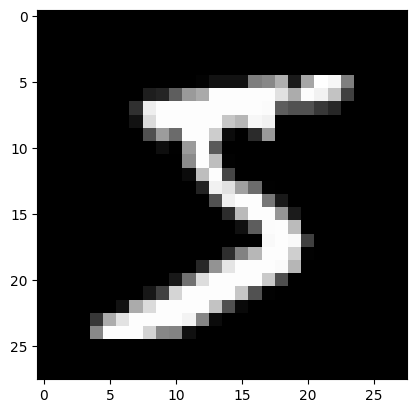

In [15]:
np.shape(first_image)
imgplot = plt.imshow(first_image, cmap="gray")

## [OPTIONAL] Train the neural network locally

Although not required for training on Vertex AI, you can train the model locally using PyTorch. This tutorial declares a `NeuralNetwork` class that inherits from PyTorch's [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=nn+module#torch.nn.Module) class. The `nn.Module` class provides a base class for all neural network modules.

In [ ]:
# Get cpu or gpu device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512, dtype=torch.float),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn) -> bool:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct
    print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    if accuracy <= 0.0:
        return False
    return True


# Define a loss function and an optimizer.
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    is_going_well = test(test_dataloader, model, loss_fn)
    if not is_going_well:
        print("unacceptable accuracy")
        break
print("Done!")

## Create training script

Setting aside all else, the main task for training a custom PyTorch model on Vertex AI is creating a training script. This script is loaded into a [pre-built container for PyTorch training](https://cloud.google.com/vertex-ai/docs/training/pre-built-containers#pytorch) that is then run as a [custom training job on Vertex AI training service](https://cloud.google.com/vertex-ai/docs/training/create-custom-job). 

The first step is to select a compatible set of accelerators and training images for your custom training job.

In [16]:
TRAIN_GPU, TEST_GPU = (aiplatform.gapic.AcceleratorType.NVIDIA_TESLA_K80, 1)
if TRAIN_GPU:
    TRAIN_VERSION = "pytorch-gpu.1-9"
else:
    TRAIN_VERSION = "pytorch-xla.1-9"

TRAIN_IMAGE = "{}-docker.pkg.dev/vertex-ai/training/{}:latest".format(
    REGION.split("-")[0], TRAIN_VERSION
)

MACHINE_TYPE = "n1-standard"

VCPU = "4"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

Train machine type n1-standard-4


### Writing out the training script

Next, you write the training script, 'task.py', to file before creating the training job. Note that the script includes the dataset, dataloader, and neural net module that you inspected previously.

In the training script, the training scripts are loaded from Cloud Storage using [Storage FUSE](https://cloud.google.com/storage/docs/gcs-fuse). FUSE mounts Cloud Storage buckets as folders in the training container's file system. This allows the training script to load files storaged in the bucket as a dataset. FUSE also allows the training script to store the output of training--the model artifact--in a Cloud Storage bucket.

To use a bucket mounted to the container using FUSE, you replace the `gs://` portion of the bucket's URI with the folder path `/gcs/`.

In [17]:
# Make folder for Python training script
if not os.path.exists("trainer"):
    os.mkdir("trainer")

In [18]:
%%writefile trainer/task.py
import sys
import os
--
import logging
import hypertune

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

parser = argparse.ArgumentParser(description='PyTorch CNN Training')
parser.add_argument('--train_uri', dest='train_uri',
                    type=str, help='Storage location of training CSV')
parser.add_argument('--test_uri', dest='test_uri',
                    type=str, help='Storage location of test CSV')
parser.add_argument('--model-dir', dest='model_dir',
                    default=os.getenv('AIP_MODEL_DIR'), type=str, help='Model directory')
parser.add_argument('--batch_size', dest='batch_size',
                    type=int, default=16, help='Batch size')
parser.add_argument('--epochs', dest='epochs',
                    type=int, default=20, help='Number of epochs')
parser.add_argument('--lr', dest='lr',
                    type=int, default=20, help='Learning rate')
args = parser.parse_args()

logging.getLogger().setLevel(logging.INFO)

class CustomImageDataset(Dataset):
    width = 28
    height = 28

    def __init__(self, data_file, transform=None, target_transform=None):
        self.dataset = pd.read_csv(data_file)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, idx):
        label = self.dataset.at[idx, "label"]
        image = self.dataset.iloc[idx,1:]

        # Create a matrix from the pandas.Series
        image = image.to_numpy() * 0.00392156862745098 # 1 / 255
        image = image.reshape(self.width, self.height)
        image = image.astype(float)
        image = torch.Tensor(image)

        if self.target_transform:
            label = self.target_transform(label)
        if self.transform:
            image = self.transform(image)
        return image, label

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512, dtype=torch.float),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def get_data(train_gcs_uri, test_gcs_uri):

    train_set = CustomImageDataset(train_gcs_uri)
    test_set = CustomImageDataset(test_gcs_uri)

    # HARDCODED batch_size and shuffle-can customize
    batch_size = 64
    shuffle = False

    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=shuffle)
    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=shuffle)

    return train_dataloader, test_dataloader

def get_model():
    logging.info("Get model architecture")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    gpu_id = "0" if torch.cuda.is_available() else None
    logging.info(f"Device: {device}")

    model = NeuralNetwork()
    model.to(device)

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    return model, loss, optimizer, device

def train_model(model, loss_func, optimizer, train_loader, test_loader, device):
    def train(dataloader, model, loss_fn, optimizer):
        size = len(dataloader.dataset)
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    def test(dataloader, model, loss_fn):
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= num_batches
        correct /= size
        accuracy = 100 * correct
        print(f"Test Error: \n Accuracy: {(accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    # Define a loss function and an optimizer.
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

    epochs = 5
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_loader, model, loss_fn, optimizer)
        test(test_loader, model, loss_fn)

    # Done training
    return model

# import data from Cloud Storage
logging.info('importing training data')
gs_prefix = 'gs://'
gcsfuse_prefix = '/gcs/'

if args.train_uri.startswith(gs_prefix):
    args.train_uri.replace(gs_prefix, gcsfuse_prefix)

if args.test_uri.startswith(gs_prefix):
    args.test_uri.replace(gs_prefix, gcsfuse_prefix)

train_dataset, test_dataset = get_data(train_gcs_uri=args.train_uri,
                                      test_gcs_uri=args.test_uri)

logging.info('starting training')
model, loss, optimizer, device = get_model()
train_model(model, loss, optimizer, train_dataset, test_dataset, device)


# export model to gcs using GCSFuse
logging.info('start saving')
logging.info("Exporting model artifacts ...")
gs_prefix = 'gs://'
gcsfuse_prefix = '/gcs/'
if args.model_dir.startswith(gs_prefix):
    args.model_dir = args.model_dir.replace(gs_prefix, gcsfuse_prefix)
    dirpath = os.path.split(args.model_dir)[0]
    if not os.path.isdir(dirpath):
        os.makedirs(dirpath)

gcs_model_path = os.path.join(os.path.join(args.model_dir, 'model.pth'))
torch.save(model.state_dict(), gcs_model_path)
logging.info(f'Model is saved to {args.model_dir}')

Writing trainer/task.py


### Create the training job

Once you have written the training script to file, you now train the model. For this model, the following parameters are provided in the call to `CustomTrainingJob.run()`. Also note that the strings provided in the `args` list are defined arguments in the training script.

+ The `--train_uri` and `--test_uri` arguments point towards CSV files available on a publicly available Cloud Storage bucket. The training script accesses the files using Storage FUSE.
+ The `--model_dir` argument point towards a Storage bucket that you must provide to the script. The training script creates a new folder on the bucket to store your model artifacts.

In [23]:
TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")
JOB_DISPLAY_NAME = "pytorch-custom-job"
TRAIN_IMAGE_URI = "us-docker.pkg.dev/vertex-ai/training/pytorch-gpu.1-13:latest"

job = aiplatform.CustomTrainingJob(
    display_name=JOB_DISPLAY_NAME,
    script_path="trainer/task.py",
    container_uri=TRAIN_IMAGE_URI
)

job.run(
    replica_count=1,
    machine_type="n1-standard-4",
    args=[
        "--train_uri",
        TRAIN_URI,
        "--test_uri",
        TEST_URI,
        "--model-dir",
        f"{BUCKET_URI}/{BUCKET_PREFIX}/{TIMESTAMP}/",
    ],
)

Training did not produce a Managed Model returning None. Training Pipeline projects/9452062936/locations/us-central1/trainingPipelines/7796328745706455040 is not configured to upload a Model. Create the Training Pipeline with model_serving_container_image_uri and model_display_name passed in. Ensure that your training script saves to model to os.environ['AIP_MODEL_DIR'].


## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:


In [ ]:
import os

# Delete training job created
job.delete(sync=False)

# Delete Cloud Storage objects that were created
delete_bucket = False
if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI